In [1]:
# import datetime
import math
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as image
from matplotlib.offsetbox import  OffsetImage

#matplotlib inline
import pyproj
import pymap3d as pm

from astropy.time import Time



In [2]:
stacode='alex'
## input data
data = pd.read_csv("data/turkeq/{}_kin03700_23.cts".format(stacode), sep=" ")

#data["dates"]
data['Lat'], data['Lon'], data['Alt'] = pm.ecef2geodetic(data['X'], data['Y'], data['Z'], ell=None, deg=True)
#data['ddate'] = pd.to_datetime(data['dates'], format='%d/%m/%Y')
#data['date'] = pd.to_datetime(data.date + data.h.astype(str),format='%d/%m/%Y %H').dt.time
#data['date']
#data['time'] =data['h'].astype(str) +':'+ data['min'].astype(str)+':'+data['sec'].astype(str)
#data['date'] = pd.to_datetime(data['ddate'].astype(str) +' '+ data['time'].astype(str))
#data['jd'] = data['mjd'] + 2400000.5

data['mjdTim'] = data['mjd']+data['sod']/(3600*24)

data['Date'] = Time(data['mjdTim'], format='mjd').datetime

#P = pyproj.Proj(proj='utm', zone=34, ellps='WGS84', preserve_units=False)
#data['utmE'], data['utmN'] = P(data['Lon'], data['Lat'])

## set index
data = data.set_index(['Date'])
data
## convert and make index to dataframwe
#time_data = "3/4/2022 12:16:25.123"
#format_data = "%d/%m/%Y"
#date = datetime.strptime(data['dates'], format_data)
#data
header= ['X','Y','Z',]
#data.to_csv('test_p2.txt', columns=header)
#utmout = data[['utmE', 'utmN', 'Alt']].copy()
#
#utmout
#utmout.to_csv('Outputs/utm_ts.txt')
data

,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim
Date,,,,,,,,,
2023-02-06 00:00:00,59981,0.0,4348024.387,2106924.037,4149806.109,40.849166,25.853456,59.826049,59981.000000
2023-02-06 00:00:01,59981,1.0,4348024.385,2106924.040,4149806.109,40.849166,25.853456,59.825677,59981.000012
2023-02-06 00:00:02,59981,2.0,4348024.387,2106924.040,4149806.108,40.849166,25.853456,59.826384,59981.000023
2023-02-06 00:00:03,59981,3.0,4348024.388,2106924.042,4149806.111,40.849166,25.853456,59.829687,59981.000035
2023-02-06 00:00:04,59981,4.0,4348024.387,2106924.042,4149806.110,40.849166,25.853456,59.828352,59981.000046
...,...,...,...,...,...,...,...,...,...
2023-02-06 21:59:55,59981,79195.0,4348024.370,2106924.027,4149806.098,40.849166,25.853456,59.803983,59981.916609
2023-02-06 21:59:56,59981,79196.0,4348024.373,2106924.027,4149806.098,40.849166,25.853456,59.806025,59981.916620
2023-02-06 21:59:57,59981,79197.0,4348024.372,2106924.029,4149806.095,40.849166,25.853456,59.804042,59981.916632


In [3]:
## convert to E N UP
meanX=data['X'].mean()
meanY=data['Y'].mean()
meanZ=data['Z'].mean()

ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
#mLon, mLat, mAlt = pyproj.transform(ecef, lla, meanX, meanY, meanZ, radians=False)
mLat, mLon, mAlt = pm.ecef2geodetic(meanX, meanY, meanZ,  ell=None, deg=True)


print(mLon, mLat, mAlt)

# mLon_r=math.radians(mLon)
# mLat_r=math.radians(mLat)
# print(meanLon, meanLat, meanAlt)

data['dX'] = data['X'] - meanX
data['dY'] = data['Y'] - meanY
data['dZ'] = data['Z'] - meanZ

## make rotational matrix
#R = [ 
#    [-math.sin(mLat_r)*math.cos(mLon_r), -math.sin(mLat_r)*math.sin(mLon_r), math.cos(mLat_r)],
#    [-math.sin(mLon_r), math.cos(mLon_r), 0],
#    [math.cos(mLat_r)*math.cos(mLon_r), math.cos(mLat_r)*math.sin(mLon_r), math.sin(mLat_r)]
#]


data['dE'], data['dN'], data['dU'] = pm.ecef2enu(data['X'], data['Y'], data['Z'], mLat, mLon, mAlt, ell=None, deg=True)
data['dN'] = data['dN']*1000.
data['dE'] = data['dE']*1000.
data['dU'] = data['dU']*1000.

#indexdN = data[ (data['dN'] >= 40) | (data['dN'] <=-40) ].index
#data.drop(indexdN , inplace=True)
header= ['X','Y','Z','dN', 'dE', 'dU']
data.to_csv('Outputs/230206_tur/smartnet/{}_enu.csv'.format(stacode), columns=header)
data

25.853456202231694 40.84916574496959 59.82154175387547


,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim,dX,dY,dZ,dE,dN,dU
Date,,,,,,,,,,,,,,,
2023-02-06 00:00:00,59981,0.0,4348024.387,2106924.037,4149806.109,40.849166,25.853456,59.826049,59981.000000,0.002036,0.000967,0.004284,-0.017495,1.765882,4.506877
2023-02-06 00:00:01,59981,1.0,4348024.385,2106924.040,4149806.109,40.849166,25.853456,59.825677,59981.000012,0.000036,0.003967,0.004284,3.554384,2.087431,4.135004
2023-02-06 00:00:02,59981,2.0,4348024.387,2106924.040,4149806.108,40.849166,25.853456,59.826384,59981.000023,0.002036,0.003967,0.003284,2.682242,0.153785,4.842383
2023-02-06 00:00:03,59981,3.0,4348024.388,2106924.042,4149806.111,40.849166,25.853456,59.829687,59981.000035,0.003036,0.005967,0.006284,4.045995,1.264040,8.145035
2023-02-06 00:00:04,59981,4.0,4348024.387,2106924.042,4149806.110,40.849166,25.853456,59.828352,59981.000046,0.002036,0.005967,0.005284,4.482066,1.096212,6.810241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06 21:59:55,59981,79195.0,4348024.370,2106924.027,4149806.098,40.849166,25.853456,59.803983,59981.916609,-0.014964,-0.009033,-0.006716,-1.603413,6.303611,-17.558795
2023-02-06 21:59:56,59981,79196.0,4348024.373,2106924.027,4149806.098,40.849166,25.853456,59.806025,59981.916620,-0.011964,-0.009033,-0.006716,-2.911626,4.537795,-15.516623
2023-02-06 21:59:57,59981,79197.0,4348024.372,2106924.029,4149806.095,40.849166,25.853456,59.804042,59981.916632,-0.012964,-0.007033,-0.009716,-0.675730,2.286656,-17.499838


In [4]:
# split dataframe into two for each earthquake

df1 = data.loc['2023-02-06 01:10:00' : '2023-02-06 01:40:00', :]

df2 = data.loc['2023-02-06 10:20:00' : '2023-02-06 10:50:00', :]


In [5]:
# rotate axes 1
from pyproj import Geod

lat_eq1 = 37.226
lon_eq1 = 37.014



lat1 = df1['Lat'][0]
lon1 = df1['Lon'][0]



#azimuth
g = Geod(ellps='WGS84') 
a1 = g.inv(lon1, lat1, lon_eq1, lat_eq1, radians=0)[0]
print(a1)
a1=math.radians(a1)

   
if a1<0:
        a1=abs(a1)
        a1=2*np.pi-a1
               
print(a1)

       
R1 = np.array([[math.cos(a1), -(math.sin(a1))],
                [(math.sin(a1)), math.cos(a1)]])
    
xy1 = df1[['dE', 'dN']].to_numpy()
uv1 = []
for item in xy1:
    uv1.append(R1.dot(item.T))
#print(uv)
uv1 = (np.array(uv1)).T
    
df1['V'] = uv1[0]
df1['U'] = uv1[1]

df1

109.0093039845358
1.9025712698375237


<ipython-input-5-a3c3f552f62e>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['V'] = uv1[0]
<ipython-input-5-a3c3f552f62e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['U'] = uv1[1]


,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim,dX,dY,dZ,dE,dN,dU,V,U
Date,,,,,,,,,,,,,,,,,
2023-02-06 01:10:00,59981,4200.0,4348024.394,2106924.049,4149806.117,40.849166,25.853456,59.840005,59981.048611,0.009036,0.012967,0.012284,7.728956,0.274465,18.462813,-2.776986,7.218064
2023-02-06 01:10:01,59981,4201.0,4348024.392,2106924.050,4149806.115,40.849166,25.853456,59.837665,59981.048623,0.007036,0.013967,0.010284,9.501010,-0.346412,16.123083,-2.767164,9.095713
2023-02-06 01:10:02,59981,4202.0,4348024.390,2106924.052,4149806.115,40.849166,25.853456,59.836963,59981.048634,0.005036,0.015967,0.010284,12.172977,0.260357,15.421352,-4.211161,11.424328
2023-02-06 01:10:03,59981,4203.0,4348024.387,2106924.049,4149806.110,40.849166,25.853456,59.830661,59981.048646,0.002036,0.012967,0.005284,10.781453,-0.900334,9.119253,-2.660518,10.486752
2023-02-06 01:10:04,59981,4204.0,4348024.384,2106924.047,4149806.107,40.849166,25.853456,59.825997,59981.048657,-0.000964,0.010967,0.002284,10.289841,-0.833378,4.455152,-2.563694,10.000141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06 01:39:56,59981,5996.0,4348024.380,2106924.039,4149806.094,40.849166,25.853456,59.812132,59981.069398,-0.004964,0.002967,-0.010716,4.834826,-6.030831,-9.409525,4.127137,6.535534
2023-02-06 01:39:57,59981,5997.0,4348024.382,2106924.040,4149806.096,40.849166,25.853456,59.815132,59981.069410,-0.002964,0.003967,-0.008716,4.862596,-5.980396,-6.410078,4.070406,6.545362
2023-02-06 01:39:58,59981,5998.0,4348024.383,2106924.041,4149806.098,40.849166,25.853456,59.817450,59981.069421,-0.001964,0.004967,-0.006716,5.326438,-5.341354,-4.091354,3.315131,6.775759


In [6]:
#rotate axis 2

lat_eq2 = 38.011
lon_eq2 = 37.196

lat2 = df2['Lat'][0]
lon2 = df2['Lon'][0]
    

a2 = g.inv(lon2, lat2, lon_eq2, lat_eq2, radians=0)[0]
print(a2)
a2=math.radians(a2)


if a2<0:
        a2=abs(a2)
        a2=2*np.pi-a2
        


R2 = np.array([[math.cos(a2), -(math.sin(a2))],
                [(math.sin(a2)), math.cos(a2)]])

xy2 = df2[['dE', 'dN']].to_numpy()
uv2 = []
for item in xy2:
    uv2.append(R2.dot(item.T))
#print(uv)
uv2 = (np.array(uv2)).T
    
df2['V'] = uv2[0]
df2['U'] = uv2[1]

df2

104.21598959787215


<ipython-input-6-54f741d43ad7>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['V'] = uv2[0]
<ipython-input-6-54f741d43ad7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['U'] = uv2[1]


,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim,dX,dY,dZ,dE,dN,dU,V,U
Date,,,,,,,,,,,,,,,,,
2023-02-06 10:20:00,59981,37200.0,4348024.390,2106924.040,4149806.114,40.849166,25.853456,59.832351,59981.430556,0.005036,0.003967,0.009284,1.374029,2.926573,10.808976,-3.174384,0.613250
2023-02-06 10:20:01,59981,37201.0,4348024.388,2106924.039,4149806.114,40.849166,25.853456,59.830659,59981.430567,0.003036,0.002967,0.009284,1.346258,4.389005,9.117669,-4.585211,0.227189
2023-02-06 10:20:02,59981,37202.0,4348024.386,2106924.039,4149806.112,40.849166,25.853456,59.827990,59981.430579,0.001036,0.002967,0.007284,2.218400,4.053348,6.448080,-4.474012,1.155053
2023-02-06 10:20:03,59981,37203.0,4348024.388,2106924.039,4149806.114,40.849166,25.853456,59.830659,59981.430590,0.003036,0.002967,0.009284,1.346258,4.389005,9.117669,-4.585211,0.227189
2023-02-06 10:20:04,59981,37204.0,4348024.387,2106924.038,4149806.115,40.849166,25.853456,59.830303,59981.430602,0.002036,0.001967,0.010284,0.882417,6.019266,8.761155,-6.051639,-0.622804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06 10:49:56,59981,38996.0,4348024.392,2106924.041,4149806.110,40.849166,25.853456,59.831426,59981.451343,0.007036,0.004967,0.005284,1.401800,-1.561595,9.884004,1.169523,1.742366
2023-02-06 10:49:57,59981,38997.0,4348024.392,2106924.040,4149806.113,40.849166,25.853456,59.833058,59981.451354,0.007036,0.003967,0.008284,0.501887,0.992928,11.516355,-1.085774,0.242677
2023-02-06 10:49:58,59981,38998.0,4348024.393,2106924.042,4149806.111,40.849166,25.853456,59.833090,59981.451366,0.008036,0.005967,0.006284,1.865641,-1.678988,11.548657,1.169412,2.220831


In [7]:
#calculate max displacements earthquake 1

#max_dN_1 = df1['dN'].abs().max()
#print(max_dN_1, end=' ')
#print(df1.index[df1["dN"]==max_dN_1].tolist())
#print(df1[df1['dN'] == max_dN_1].index.values[0], end=' ')
#print(df1[df1['dN'] == max_dN_1].index.strftime('%m/%d/%Y, %r'))


#print(t_dN1,end=' ')
#f1.index = pd.to_datetime(df1[df1['dN'] == max_dN_1].index.values)
    
#max_dE_1 = df1['dE'].abs().max()
#print(max_dE_1,end=' ')
#print(df1[df1['dE'] == max_dE_1].index.values,end=' ')

#max_U_1 = df1['U'].abs().max()
#print(max_U_1,end=' ')
#print(df1[df1['U'] == max_U_1].index.values[0],end=' ')

#max_V_1 = df1['V'].abs().max()
#print(max_V_1,end=' ')a
#print(df1[df1['V'] == max_V_1].index.values[0])

#df1

df1s = df1.loc['2023-02-06 01:21:00' : '2023-02-06 01:30:00', :]

line = '{} '.format(stacode)
for c in ['dN', 'dE', 'U', 'V']:
    max_c = df1s[c].max()
    min_c = df1s[c].min()
    if abs(max_c) > abs(min_c) :
        max_d = max_c
    else:
        max_d = min_c
        
    max_t = df1s[df1s[c] == max_d].index.values[0]
    
    #max_t = max_t[0] if len(max_t)>0 else None
    #print('max {:} epoch: {:}'.format(max_c, max_t))
    line += '{:} {:} '.format(max_c, max_t)
print(line)

## output file format: code dn time de time U time V time
#fout =  open('Outputs/output_eq1.txt','a')

with open("Outputs/output_eq1_v2.txt", "a") as fout:
    fout.write("{:} \n".format(line))
fout.close()


alex 18.662792200067447 2023-02-06T01:23:23.000000000 16.069844487405412 2023-02-06T01:24:41.000000000 15.863486256741137 2023-02-06T01:24:41.000000000 18.719384905282435 2023-02-06T01:23:35.000000000 


In [8]:
#calculate max displacements earthquake 2

#max_dN_2 = df2['dN'].abs().max()
#print(max_dN_2)
#print(df2[df2['dN'] == max_dN_2].index.values)
    
#max_dE_2 = df2['dE'].abs().max()
#print(max_dE_2)
#print(df2[df2['dE'] == max_dE_2].index.values)

#max_U_2 = df2['U'].abs().max()
#print(max_U_2)
#print(df2[df2['U'] == max_U_2].index.values)

#max_V_2 = df2['V'].abs().max()
#print(max_V_2)
#print(df2[df2['V'] == max_V_2].index.values)

df2s = df2.loc['2023-02-06 10:27:00' : '2023-02-06 10:37:00', :]

line = '{} '.format(stacode)
for c in ['dN', 'dE', 'U', 'V']:
    max_c = df2s[c].max()
    max_t = df2s[df2s[c] == max_c].index.values[0]
    #max_t = max_t[0] if len(max_t)>0 else None
    #print('max {:} epoch: {:}'.format(max_c, max_t))
    line += '{:} {:} '.format(max_c, max_t)
print(line)

## output file format: code dn time de time U time V time
#fout =  open('Outputs/output_eq1.txt','a')

with open("Outputs/output_eq2_v2.txt", "a") as fout:
    fout.write("{:} \n".format(line))
fout.close()


alex 38.23084977272451 2023-02-06T10:30:29.000000000 14.27001998190289 2023-02-06T10:30:41.000000000 12.570769679966265 2023-02-06T10:31:26.000000000 34.92009448334375 2023-02-06T10:30:20.000000000 


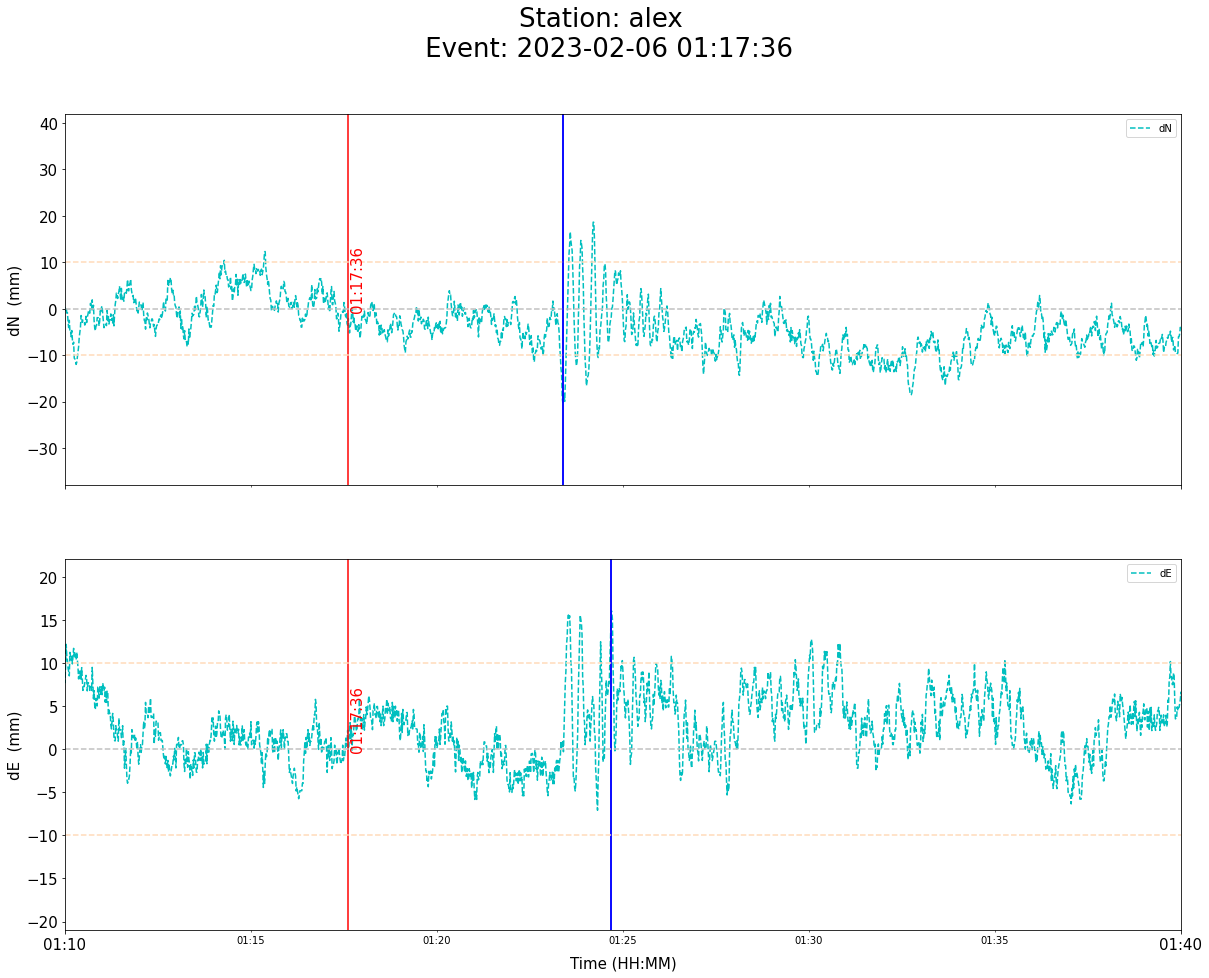

In [9]:
## PLOT NE EQ1
## make time series for the three axes
fig, axes = plt.subplots(2, 1, figsize=(20,15), sharex=True,)
fig.suptitle('Station: {} \n Event: 2023-02-06 01:17:36'.format(stacode), fontsize=26)


#plot_cols = ['dN', 'dE', 'dU' ]
plot_cols = ['dN', 'dE']
#plot_cols = ['dX', 'dY', 'dZ' ]

data[plot_cols].plot(subplots=True, ax=axes, linestyle='--', marker='', color='c')

#month_day_formatter = mdates.DateFormatter("%Y-%m-%d")
month_day_formatter = mdates.DateFormatter("%H:%M:%S")

ylimits = [[-30,30],[-20,20],[-30,30]]
#ylimits = [[-70,70],[-70,70],[-60,60]]

    
max_dN = df1s['dN'].max()
min_dN = df1s['dN'].min()
if abs(max_dN) > abs(min_dN) :
    max_dN = max_dN
else:
    max_dN = min_dN
max_tdN = df1s[df1s['dN'] == max_dN].index.values[0]

max_dE = df1s['dE'].max()
min_dE = df1s['dE'].min()
if abs(max_dE) > abs(min_dE) :
    max_dE = max_dE
else:
    max_dE = min_dE
max_tdE = df1s[df1s['dE'] == max_dE].index.values[0]


for i, (ax, col) in enumerate(zip(axes, plot_cols)):
    # add axis labels
    ax.set_ylabel(col + '  (mm)',fontsize=15)
    ax.set_xlabel('Time (HH:MM)', fontsize=15)
#    ax.xaxis.set_major_formatter(month_day_formatter)
    ax.set_xlim([pd.Timestamp('2023-02-06 01:10:00'), pd.Timestamp('2023-02-06 01:40:00')])
#    ax.set_xlim([pd.Timestamp('2023-02-06 10:20:00'), pd.Timestamp('2023-02-06 10:45:00')])
    #ax.set_ylim([-30,30])
#    ax.set_ylim(ylimits[i])
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
##EVIA PERIVOLIA
    #ax.axvline(pd.Timestamp('2022-11-29 04:32:36'),color='r')
    #ax.axvline(pd.Timestamp('2022-11-29 20:06:39'),color='r')
##EVIA PSAXNA - XALKIDA
    ax.axvline(pd.Timestamp('2023-02-06 01:17:36'), color='r')
    ax.axvline(pd.Timestamp('2023-02-06 10:24:49'), color='r')
    ax.text(pd.Timestamp('2023-02-06 01:17:40'), 0, '01:17:36', size=15, color='r', rotation=90)
#    ax.text(pd.Timestamp('2023-02-06 10:24:55'), 0, '10:24:49', size=15, color='r', rotation=90)

## Add max disp 
    axes[0].axvline(pd.Timestamp('{}'.format(max_tdN)), color='b')
    axes[1].axvline(pd.Timestamp('{}'.format(max_tdE)), color='b')
    
    
    ax.axhline(y=0, linestyle='--', color='silver')
    ax.axhline(y=10, linestyle='--', color='peachpuff')
    ax.axhline(y=-10, linestyle='--', color='peachpuff')
    
#    ax.axhline(y=-160, linestyle='--', color='mistyrose')
#    ax.axhline(y=120, linestyle='--', color='mistyrose')




##########0117
#    ax.axvspan(pd.Timestamp('2023-02-06 01:20:30'), pd.Timestamp('2023-02-06 01:22:50'), alpha=0.1, color='r') #ARUC
#    ax.axvspan(pd.Timestamp('2023-02-06 01:20:30'), pd.Timestamp('2023-02-06 01:22:50'), alpha=0.1, color='r') #BSHM
#    ax.axvspan(pd.Timestamp('2023-02-06 01:19:50'), pd.Timestamp('2023-02-06 01:25:20'), alpha=0.1, color='r') #NICO
#    ax.axvspan(pd.Timestamp('2023-02-06 01:23:30'), pd.Timestamp('2023-02-06 01:25:40'), alpha=0.1, color='r') #DYNG
##########1024
#    ax.axvspan(pd.Timestamp('2023-02-06 10:27:50'), pd.Timestamp('2023-02-06 10:29:30'), alpha=0.1, color='r') #ARUC
#    ax.axvspan(pd.Timestamp('2023-02-06 10:27:30'), pd.Timestamp('2023-02-06 10:29:30'), alpha=0.1, color='r') #BSHM
#    ax.axvspan(pd.Timestamp('2023-02-06 10:29:37'), pd.Timestamp('2023-02-06 10:31:00'), alpha=0.1, color='r') #NICO
#    ax.axvspan(pd.Timestamp('2023-02-06 10:26:10'), pd.Timestamp('2023-02-06 10:32:40'), alpha=0.1, color='r') #DYNG


In [10]:
## ADD LOGO+SAVE IMAGE
logo=image.imread("./logo/dso_ww_en.png")
addLogo = OffsetImage(logo, zoom=0.4)
#addLogo.set_zorder(100)
addLogo.set_offset((200,1000)) # pass the position in a tuple
ax.add_artist(addLogo)
#height = [0, 0, 0, 0, 0]
#bars = ('A', 'B', 'C', 'D', 'E')
#y = np.arange(len(bars))
#plt.bar(y, height, color=(0.2, 0.4, 0.6, 0.6))
## Save the figure
## =================================================================================
fig.savefig("Outputs/230206_tur01/{}_ne.jpg".format(stacode))
## =================================================================================

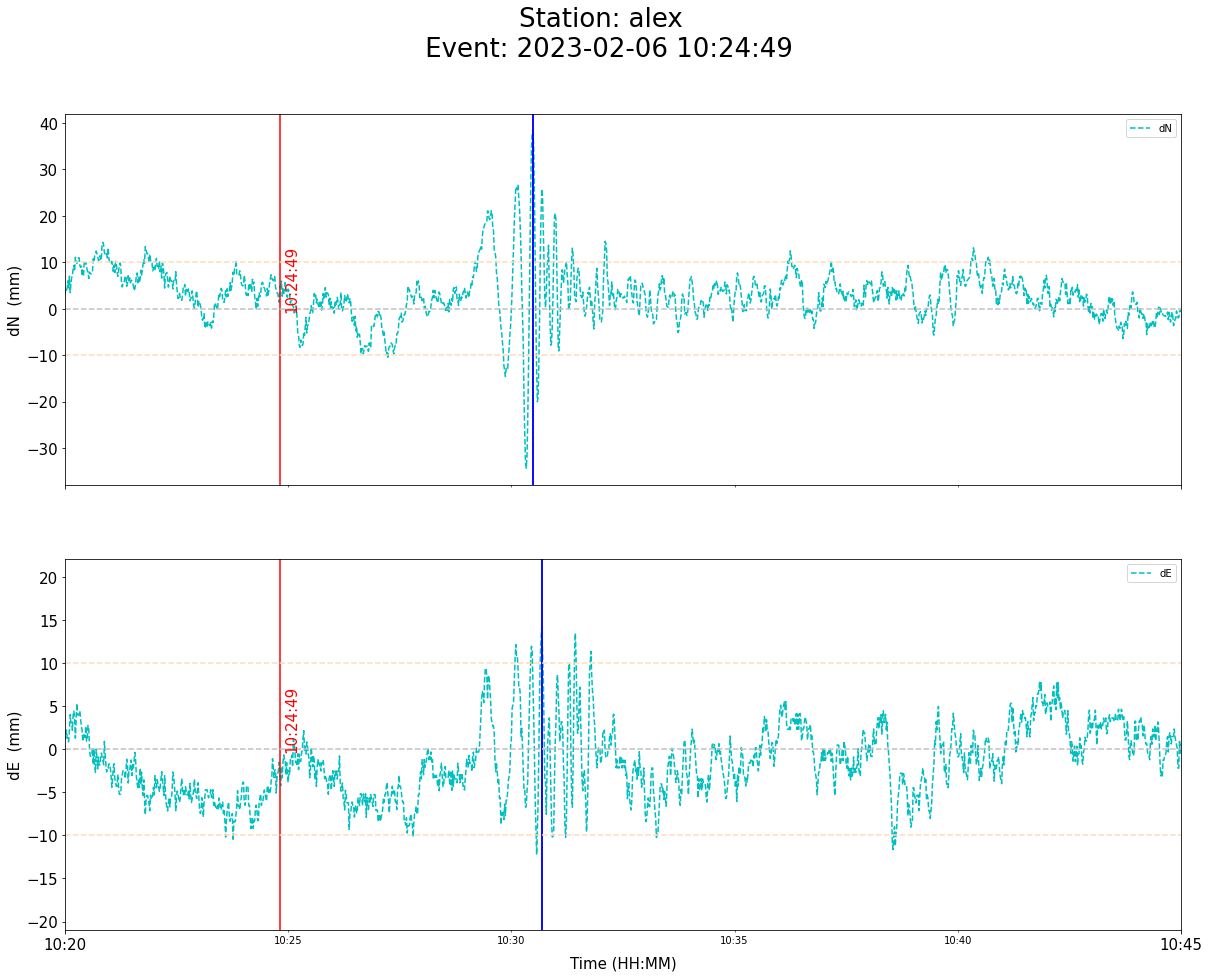

In [11]:
## PLOT NE EQ2
## make time series for the three axes
fig, axes = plt.subplots(2, 1, figsize=(20,15), sharex=True,)
fig.suptitle('Station: {} \n Event: 2023-02-06 10:24:49'.format(stacode), fontsize=26)


#plot_cols = ['dN', 'dE', 'dU' ]
plot_cols = ['dN', 'dE']
#plot_cols = ['dX', 'dY', 'dZ' ]

data[plot_cols].plot(subplots=True, ax=axes, linestyle='--', marker='', color='c')

#month_day_formatter = mdates.DateFormatter("%Y-%m-%d")
month_day_formatter = mdates.DateFormatter("%H:%M:%S")

ylimits = [[-30,30],[-20,20],[-30,30]]
#ylimits = [[-70,70],[-70,70],[-60,60]]

    
max_dN = df2s['dN'].max()
min_dN = df2s['dN'].min()
if abs(max_dN) > abs(min_dN) :
    max_dN = max_dN
else:
    max_dN = min_dN
max_tdN = df2s[df2s['dN'] == max_dN].index.values[0]

max_dE = df2s['dE'].max()
min_dE = df2s['dE'].min()
if abs(max_dE) > abs(min_dE) :
    max_dE = max_dE
else:
    max_dE = min_dE
max_tdE = df2s[df2s['dE'] == max_dE].index.values[0]


for i, (ax, col) in enumerate(zip(axes, plot_cols)):
    # add axis labels
    ax.set_ylabel(col + '  (mm)',fontsize=15)
    ax.set_xlabel('Time (HH:MM)', fontsize=15)
#    ax.xaxis.set_major_formatter(month_day_formatter)
#    ax.set_xlim([pd.Timestamp('2023-02-06 01:10:00'), pd.Timestamp('2023-02-06 01:40:00')])
    ax.set_xlim([pd.Timestamp('2023-02-06 10:20:00'), pd.Timestamp('2023-02-06 10:45:00')])
    #ax.set_ylim([-30,30])
#    ax.set_ylim(ylimits[i])
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
##EVIA PERIVOLIA
    #ax.axvline(pd.Timestamp('2022-11-29 04:32:36'),color='r')
    #ax.axvline(pd.Timestamp('2022-11-29 20:06:39'),color='r')
##EVIA PSAXNA - XALKIDA
    ax.axvline(pd.Timestamp('2023-02-06 01:17:36'), color='r')
    ax.axvline(pd.Timestamp('2023-02-06 10:24:49'), color='r')
#    ax.text(pd.Timestamp('2023-02-06 01:17:40'), 0, '01:17:36', size=15, color='r', rotation=90)
    ax.text(pd.Timestamp('2023-02-06 10:24:55'), 0, '10:24:49', size=15, color='r', rotation=90)

## Add max disp 
    axes[0].axvline(pd.Timestamp('{}'.format(max_tdN)), color='b')
    axes[1].axvline(pd.Timestamp('{}'.format(max_tdE)), color='b')
    
    
    ax.axhline(y=0, linestyle='--', color='silver')
    ax.axhline(y=10, linestyle='--', color='peachpuff')
    ax.axhline(y=-10, linestyle='--', color='peachpuff')
    
#    ax.axhline(y=-160, linestyle='--', color='mistyrose')
#    ax.axhline(y=120, linestyle='--', color='mistyrose')




##########0117
#    ax.axvspan(pd.Timestamp('2023-02-06 01:20:30'), pd.Timestamp('2023-02-06 01:22:50'), alpha=0.1, color='r') #ARUC
#    ax.axvspan(pd.Timestamp('2023-02-06 01:20:30'), pd.Timestamp('2023-02-06 01:22:50'), alpha=0.1, color='r') #BSHM
#    ax.axvspan(pd.Timestamp('2023-02-06 01:19:50'), pd.Timestamp('2023-02-06 01:25:20'), alpha=0.1, color='r') #NICO
#    ax.axvspan(pd.Timestamp('2023-02-06 01:23:30'), pd.Timestamp('2023-02-06 01:25:40'), alpha=0.1, color='r') #DYNG
##########1024
#    ax.axvspan(pd.Timestamp('2023-02-06 10:27:50'), pd.Timestamp('2023-02-06 10:29:30'), alpha=0.1, color='r') #ARUC
#    ax.axvspan(pd.Timestamp('2023-02-06 10:27:30'), pd.Timestamp('2023-02-06 10:29:30'), alpha=0.1, color='r') #BSHM
#    ax.axvspan(pd.Timestamp('2023-02-06 10:29:37'), pd.Timestamp('2023-02-06 10:31:00'), alpha=0.1, color='r') #NICO
#    ax.axvspan(pd.Timestamp('2023-02-06 10:26:10'), pd.Timestamp('2023-02-06 10:32:40'), alpha=0.1, color='r') #DYNG


In [12]:
## ADD LOGO+SAVE IMAGE
logo=image.imread("./logo/dso_ww_en.png")
addLogo = OffsetImage(logo, zoom=0.4)
#addLogo.set_zorder(100)
addLogo.set_offset((200,1000)) # pass the position in a tuple
ax.add_artist(addLogo)
#height = [0, 0, 0, 0, 0]
#bars = ('A', 'B', 'C', 'D', 'E')
#y = np.arange(len(bars))
#plt.bar(y, height, color=(0.2, 0.4, 0.6, 0.6))
## Save the figure
## =================================================================================
fig.savefig("Outputs/230206_tur02/{}_ne.jpg".format(stacode))
## =================================================================================

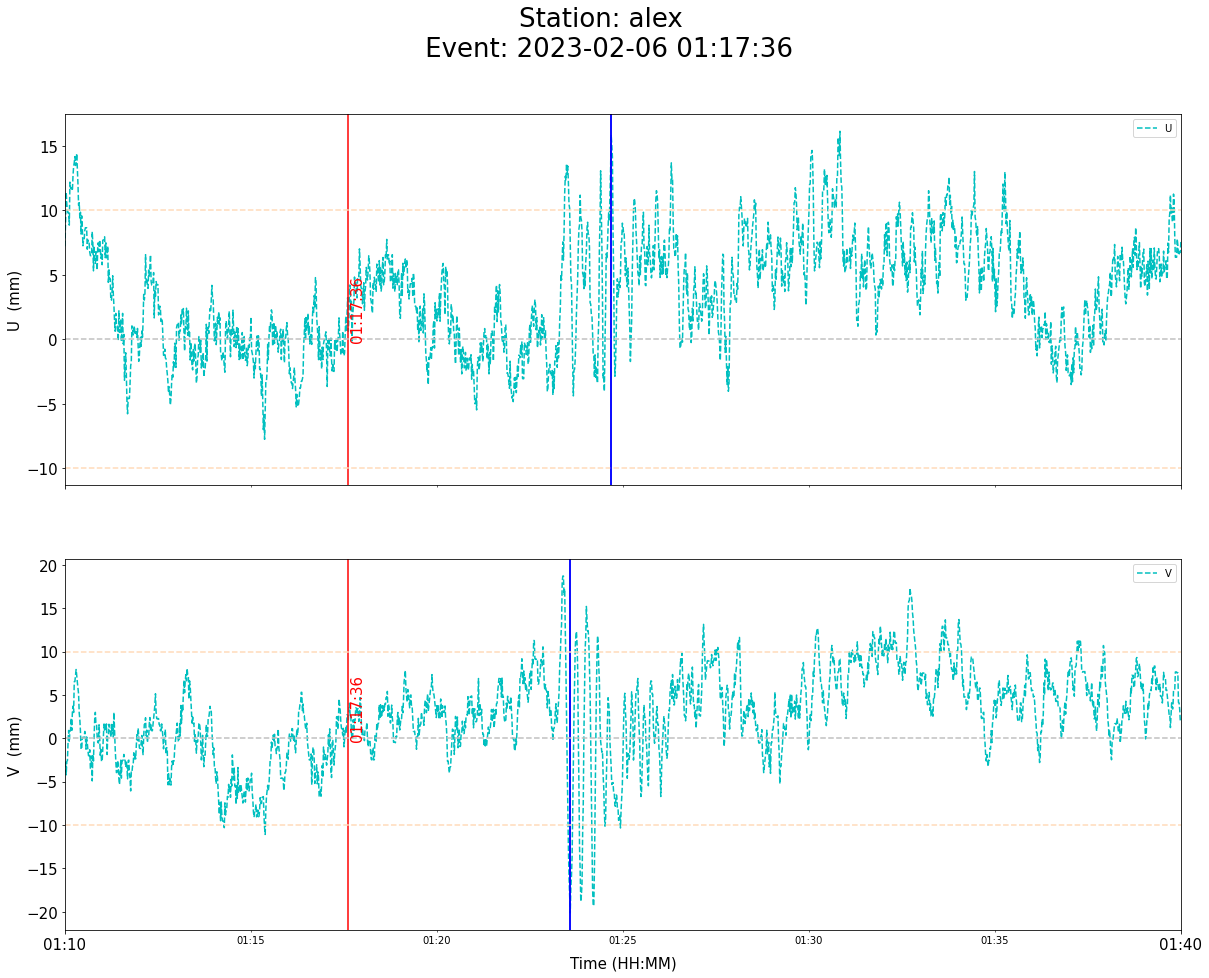

In [13]:
## PLOT UV eq1
## make time series for the three axes
fig, axes = plt.subplots(2, 1, figsize=(20,15), sharex=True,)
fig.suptitle('Station: {} \n Event: 2023-02-06 01:17:36'.format(stacode), fontsize=26)


#plot_cols = ['dN', 'dE', 'dU' ]
plot_cols = ['U', 'V']
#plot_cols = ['dX', 'dY', 'dZ' ]

df1[plot_cols].plot(subplots=True, ax=axes, linestyle='--', marker='', color='c')

#month_day_formatter = mdates.DateFormatter("%Y-%m-%d")
month_day_formatter = mdates.DateFormatter("%H:%M:%S")

#ylimits = [[-30,30],[-20,20],[-30,30]]
#ylimits = [[-70,70],[-70,70],[-60,60]]

max_dU = df1s['U'].max()
min_dU = df1s['U'].min()
if abs(max_dU) > abs(min_dU) :
    max_dU = max_dU
else:
    max_dU = min_dU
max_tdU = df1s[df1s['U'] == max_dU].index.values[0]

max_dV = df1s['V'].max()
min_dV = df1s['V'].min()
if abs(max_dV) > abs(min_dV) :
    max_dV = max_dV
else:
    max_dV = min_dV
max_tdV = df1s[df1s['V'] == max_dV].index.values[0]


for i, (ax, col) in enumerate(zip(axes, plot_cols)):
    # add axis labels
    ax.set_ylabel(col + '  (mm)',fontsize=15)
    ax.set_xlabel('Time (HH:MM)', fontsize=15)
#    ax.xaxis.set_major_formatter(month_day_formatter)
    ax.set_xlim([pd.Timestamp('2023-02-06 01:10:00'), pd.Timestamp('2023-02-06 01:40:00')])
#    ax.set_xlim([pd.Timestamp('2023-02-06 10:20:00'), pd.Timestamp('2023-02-06 10:45:00')])
    #ax.set_ylim([-30,30])
#    ax.set_ylim(ylimits[i])
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
##EVIA PERIVOLIA
    #ax.axvline(pd.Timestamp('2022-11-29 04:32:36'),color='r')
    #ax.axvline(pd.Timestamp('2022-11-29 20:06:39'),color='r')
##EVIA PSAXNA - XALKIDA
    ax.axvline(pd.Timestamp('2023-02-06 01:17:36'), color='r')
    ax.axvline(pd.Timestamp('2023-02-06 10:24:49'), color='r')
    ax.text(pd.Timestamp('2023-02-06 01:17:40'), 0, '01:17:36', size=15, color='r', rotation=90)
#    ax.text(pd.Timestamp('2023-02-06 10:24:55'), 0, '10:24:49', size=15, color='r', rotation=90)

## Add max disp 
    axes[0].axvline(pd.Timestamp('{}'.format(max_tdU)), color='b')
    axes[1].axvline(pd.Timestamp('{}'.format(max_tdV)), color='b')
    
    
    ax.axhline(y=0, linestyle='--', color='silver')
    ax.axhline(y=10, linestyle='--', color='peachpuff')
    ax.axhline(y=-10, linestyle='--', color='peachpuff')
#    ax.axhline(y=-160, linestyle='--', color='mistyrose')
#    ax.axhline(y=120, linestyle='--', color='mistyrose')


In [14]:
## ADD LOGO+SAVE IMAGE
logo=image.imread("./logo/dso_ww_en.png")
addLogo = OffsetImage(logo, zoom=0.4)
#addLogo.set_zorder(100)
addLogo.set_offset((200,1000)) # pass the position in a tuple
ax.add_artist(addLogo)
#height = [0, 0, 0, 0, 0]
#bars = ('A', 'B', 'C', 'D', 'E')
#y = np.arange(len(bars))
#plt.bar(y, height, color=(0.2, 0.4, 0.6, 0.6))
## Save the figure
## =================================================================================
fig.savefig("Outputs/230206_tur01/{}_uv.jpg".format(stacode))
## =================================================================================

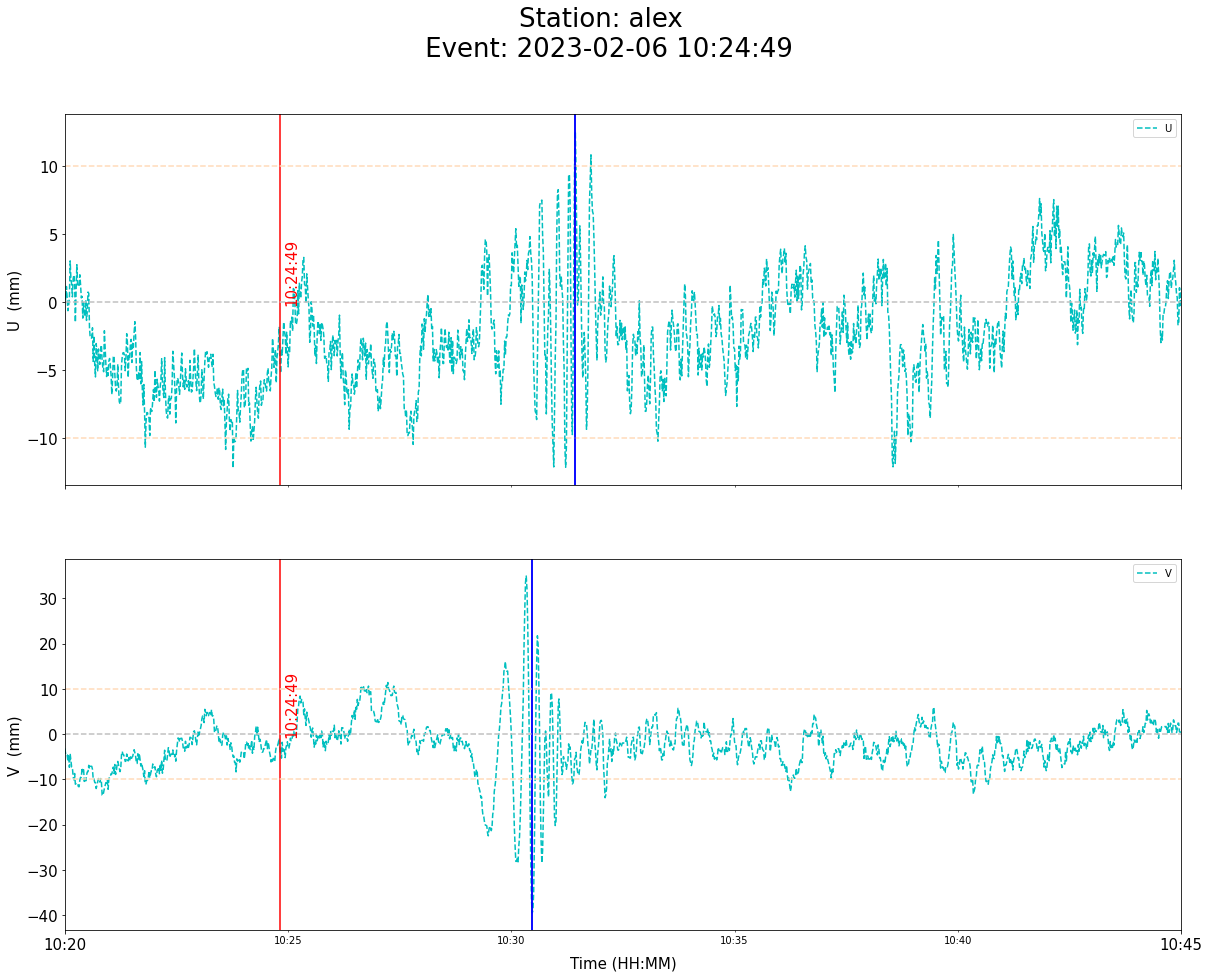

In [15]:
## PLOT UV EQ2
## make time series for the three axes
fig, axes = plt.subplots(2, 1, figsize=(20,15), sharex=True,)
fig.suptitle('Station: {} \n Event: 2023-02-06 10:24:49'.format(stacode), fontsize=26)


#plot_cols = ['dN', 'dE', 'dU' ]
plot_cols = ['U', 'V']
#plot_cols = ['dX', 'dY', 'dZ' ]

df2[plot_cols].plot(subplots=True, ax=axes, linestyle='--', marker='', color='c')

#month_day_formatter = mdates.DateFormatter("%Y-%m-%d")
month_day_formatter = mdates.DateFormatter("%H:%M:%S")

#ylimits = [[-30,30],[-20,20],[-30,30]]
#ylimits = [[-70,70],[-70,70],[-60,60]]

max_dU = df2s['U'].max()
min_dU = df2s['U'].min()
if abs(max_dU) > abs(min_dU) :
    max_dU = max_dU
else:
    max_dU = min_dU
max_tdU = df2s[df2s['U'] == max_dU].index.values[0]

max_dV = df2s['V'].max()
min_dV = df2s['V'].min()
if abs(max_dV) > abs(min_dV) :
    max_dV = max_dV
else:
    max_dV = min_dV
max_tdV = df2s[df2s['V'] == max_dV].index.values[0]


for i, (ax, col) in enumerate(zip(axes, plot_cols)):
    # add axis labels
    ax.set_ylabel(col + '  (mm)',fontsize=15)
    ax.set_xlabel('Time (HH:MM)', fontsize=15)
#    ax.xaxis.set_major_formatter(month_day_formatter)
#    ax.set_xlim([pd.Timestamp('2023-02-06 01:10:00'), pd.Timestamp('2023-02-06 01:40:00')])
    ax.set_xlim([pd.Timestamp('2023-02-06 10:20:00'), pd.Timestamp('2023-02-06 10:45:00')])
    #ax.set_ylim([-30,30])
#    ax.set_ylim(ylimits[i])
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
##EVIA PERIVOLIA
    #ax.axvline(pd.Timestamp('2022-11-29 04:32:36'),color='r')
    #ax.axvline(pd.Timestamp('2022-11-29 20:06:39'),color='r')
##EVIA PSAXNA - XALKIDA
#    ax.axvline(pd.Timestamp('2023-02-06 01:17:36'), color='r')
    ax.axvline(pd.Timestamp('2023-02-06 10:24:49'), color='r')
#    ax.text(pd.Timestamp('2023-02-06 01:17:40'), 0, '01:17:36', size=15, color='r', rotation=90)
    ax.text(pd.Timestamp('2023-02-06 10:24:55'), 0, '10:24:49', size=15, color='r', rotation=90)

## Add max disp 
    axes[0].axvline(pd.Timestamp('{}'.format(max_tdU)), color='b')
    axes[1].axvline(pd.Timestamp('{}'.format(max_tdV)), color='b')
    
    
    ax.axhline(y=0, linestyle='--', color='silver')
    ax.axhline(y=10, linestyle='--', color='peachpuff')
    ax.axhline(y=-10, linestyle='--', color='peachpuff')
#    ax.axhline(y=-160, linestyle='--', color='mistyrose')
#    ax.axhline(y=120, linestyle='--', color='mistyrose')


In [16]:
## ADD LOGO+SAVE IMAGE
logo=image.imread("./logo/dso_ww_en.png")
addLogo = OffsetImage(logo, zoom=0.4)
#addLogo.set_zorder(100)
addLogo.set_offset((200,1000)) # pass the position in a tuple
ax.add_artist(addLogo)
#height = [0, 0, 0, 0, 0]
#bars = ('A', 'B', 'C', 'D', 'E')
#y = np.arange(len(bars))
#plt.bar(y, height, color=(0.2, 0.4, 0.6, 0.6))
## Save the figure
## =================================================================================
fig.savefig("Outputs/230206_tur02/{}_uv.jpg".format(stacode))
## =================================================================================

In [17]:
#fig, ax = plt.subplots(figsize=(15,15))
#DN=data.loc[(data.index > '2023-02-06 01:18:00') & (data.index < '2023-02-06 01:20:00'), 'dN']
#DE=data.loc[(data.index > '2023-02-06 01:18:00') & (data.index < '2023-02-06 01:20:00'), 'dE']
#ax.scatter(DN, DE, marker='o',linestyle='-', color='r') 
#ax.plot(DN, DE, marker='',linestyle='-') 

In [18]:
#from hhpy.plotting import animplot

#animplot(data=data, x='dE', y='dN', t='sod', t_format='%S')

In [19]:
#anim.save('Outputs/230206_tur/animation.gif', writer='imagemagick', fps=60)

#data.index